In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import time

In [2]:
image_train=np.load("image_train.npy")
label_train=np.load("label_train.npy")
image_test=np.load("image_test.npy")
label_test=np.load("label_test.npy")

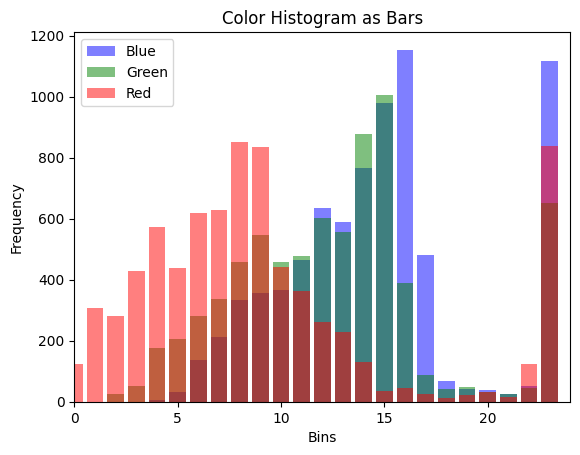

In [3]:
train_b_HG=[]
train_g_HG=[]
train_r_HG=[]
test_b_HG=[]
test_g_HG=[]
test_r_HG=[]

div=24
for image in image_train:
    image_np = np.array(image)
    train_b_HG.append(cv.calcHist([image_np], [2], None, [div], [0, 255]))
    train_g_HG.append(cv.calcHist([image_np], [1], None, [div], [0, 255]))
    train_r_HG.append(cv.calcHist([image_np], [0], None, [div], [0, 255]))

for image in image_test:
    image_np = np.array(image)
    test_b_HG.append(cv.calcHist([image_np], [2], None, [div], [0, 255]))
    test_g_HG.append(cv.calcHist([image_np], [1], None, [div], [0, 255]))
    test_r_HG.append(cv.calcHist([image_np], [0], None, [div], [0, 255]))


train_histograms = [
    np.concatenate((b.flatten(), g.flatten(), r.flatten()))
    for b, g, r in zip(train_b_HG, train_g_HG, train_r_HG)
]
test_histograms = [
    np.concatenate((b.flatten(), g.flatten(), r.flatten()))
    for b, g, r in zip(test_b_HG, test_g_HG, test_r_HG)
]

train_histograms = np.array(train_histograms)
test_histograms = np.array(test_histograms)


plt.xlim([0, div])
img_num = 50


# Plot histogram as usual bars
plt.bar(range(len(train_b_HG[img_num])), train_b_HG[img_num].flatten(), color='b', alpha=0.5, label='Blue')
plt.bar(range(len(train_g_HG[img_num])), train_g_HG[img_num].flatten(), color='g', alpha=0.5, label='Green')
plt.bar(range(len(train_r_HG[img_num])), train_r_HG[img_num].flatten(), color='r', alpha=0.5, label='Red')
plt.title('Color Histogram as Bars')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [4]:
train_histograms_squr = np.sqrt(train_histograms) #adding nonlinearity to the data
test_histograms_squr = np.sqrt(test_histograms)

train_histograms=np.concatenate((train_histograms,train_histograms_squr),axis=1)
test_histograms=np.concatenate((test_histograms,test_histograms_squr),axis=1)


all_data=np.concatenate((train_histograms,test_histograms),axis=0)
mean=np.mean(all_data,axis=0)
std=np.std(all_data,axis=0)

train_histograms=(train_histograms-mean)/std
test_histograms=(test_histograms-mean)/std


print(train_histograms.shape)
print(test_histograms.shape)


(70491, 144)
(23619, 144)


In [ ]:
def k_means(data, k, max_iters=10000, tol=1e-5):
    
    n_samples, _ = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    
    for i in range(max_iters):
        distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        error=np.linalg.norm(new_centroids - centroids)

        if error < tol:
            print(error)
            break
        
        centroids = new_centroids

    return labels, centroids


def calculate_cluster_labels(labels_train, label_train, k):
    cluster_labels = np.empty(k, dtype=object)  # Use dtype=object for non-numeric labels

    for i in range(k):
        cluster_indices = np.where(labels_train == i)[0]
        true_labels = label_train[cluster_indices].flatten()

        if len(true_labels) > 0: 
            unique_labels, counts = np.unique(true_labels, return_counts=True)
            cluster_labels[i] = unique_labels[np.argmax(counts)]

    # Map each data point's cluster to its corresponding label
    predicted_labels = np.array([cluster_labels[label] for label in labels_train])

    # Calculate accuracy
    accuracy = np.mean(predicted_labels.flatten() == label_train.flatten())
    
    return cluster_labels, predicted_labels, accuracy

def predict(test_data, centroids):
    distances = np.linalg.norm(test_data[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(distances, axis=1)


In [6]:
# Run K-Means clustering on the training histograms
k = 141  # Number of clusters
labels_train, centroids = k_means(train_histograms, k)

Iteration 1/10000
Elapsed time: 63.35855293273926 seconds
Iteration 2/10000
Elapsed time: 7.131159543991089 seconds
Iteration 3/10000
Elapsed time: 6.087530136108398 seconds
Iteration 4/10000
Elapsed time: 5.603918552398682 seconds
Iteration 5/10000
Elapsed time: 5.498899221420288 seconds
Iteration 6/10000
Elapsed time: 5.484356164932251 seconds
Iteration 7/10000
Elapsed time: 5.346824884414673 seconds
Iteration 8/10000
Elapsed time: 5.1870317459106445 seconds
Iteration 9/10000
Elapsed time: 5.709149122238159 seconds
Iteration 10/10000
Elapsed time: 5.45223069190979 seconds
Iteration 11/10000
Elapsed time: 5.391238689422607 seconds
Iteration 12/10000
Elapsed time: 5.35397744178772 seconds
Iteration 13/10000
Elapsed time: 5.406529664993286 seconds
Iteration 14/10000
Elapsed time: 5.317023038864136 seconds
Iteration 15/10000
Elapsed time: 5.261552095413208 seconds
Iteration 16/10000
Elapsed time: 5.1322996616363525 seconds
Iteration 17/10000
Elapsed time: 5.207324504852295 seconds
Iterat

In [18]:

cluster_labels, predicted_labels, accuracy = calculate_cluster_labels(labels_train, label_train, k)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 75.90%


In [19]:

example = 9811

labels_test = predict(test_histograms[example].reshape(1, -1), centroids)

predicted_labels = np.array([cluster_labels[label] for label in labels_test])

print(predicted_labels)
print(label_test[example])

['Hazelnut 1']
Hazelnut 1
